
# RL Simulator



In [1]:
# Install the gymnasium library for creating and using reinforcement learning environments.
%pip install gymnasium

In [2]:
# Authenticate with Google Cloud to access services like BigQuery.
from google.colab import auth
auth.authenticate_user()

# Import the BigQuery client library.
from google.cloud import bigquery
# Initialize a BigQuery client with your project ID.
client = bigquery.Client(project="rl-semester-project")

In [3]:
# Import the BigQuery client library.
from google.cloud import bigquery
# Initialize the BigQuery client with the correct project ID
client = bigquery.Client(project="rl-semester-project")

# Define the public project, dataset, and table to query.
public_proj = "google.com:google-cluster-data"
dataset     = "clusterdata_2019_h"
table       = "instance_usage"

# SQL query to retrieve schema information for the 'instance_usage' table
schema_df = client.query(f"""
SELECT
  column_name,  -- Select the column name
  data_type     -- Select the data type of the column
FROM `{public_proj}.{dataset}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{table}' -- Filter for the specified table
ORDER BY ordinal_position   -- Order by the position of the column in the table
""").to_dataframe()

# Display the schema information in a DataFrame.
schema_df

,column_name,data_type
0,start_time,INT64
1,end_time,INT64
2,collection_id,INT64
3,instance_index,INT64
4,machine_id,INT64
5,alloc_collection_id,INT64
6,alloc_instance_index,INT64
7,collection_type,INT64
8,average_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"
9,maximum_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"


Aggregate CPU and memory load from instance_usage:

In [4]:
# SQL query to aggregate CPU and memory usage from the 'instance_usage' table
sql = """
SELECT
  # Truncate the start time to the minute to create time windows
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(start_time), MINUTE) AS time_window,
  # Calculate the average CPU usage for each time window
  AVG(average_usage.cpus) AS avg_cpu,
  # Calculate the average memory usage for each time window
  AVG(average_usage.memory) AS avg_mem,
  # Count the number of distinct machines active in each time window
  COUNT(DISTINCT machine_id) AS active_machines
FROM `google.com:google-cluster-data.clusterdata_2019_a.instance_usage`
# Group the results by the time window
GROUP BY time_window
# Order the results by the time window
ORDER BY time_window
# Limit the results to the first 10000 rows
LIMIT 10000
"""
# Execute the BigQuery query and load the results into a pandas DataFrame
df_usage = client.query(sql).to_dataframe()
# Display the first few rows of the DataFrame
df_usage.head()

,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167
3,1970-01-01 00:08:00+00:00,0.001950,0.001823,4338
4,1970-01-01 00:09:00+00:00,0.001689,0.001468,5545


In [5]:
# Inspect the shape of the DataFrame (number of rows and columns)
print(df_usage.shape)
# Print the list of column names
print(df_usage.columns.tolist())
# Display the first 3 rows of the DataFrame to get a preview of the data
df_usage.head(3)

(10000, 4)
['time_window', 'avg_cpu', 'avg_mem', 'active_machines']


,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167


In [6]:
#Make sure the time series is in order, since RL transitions depend on consecutive steps:
df_usage = df_usage.sort_values("time_window").reset_index(drop=True)
df_usage.head(3)

,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167


## Building the Simulated RL Environment

Based on the EDA, we will now build a simulated reinforcement learning environment for autoscaling.



### Approach to Building the Simulated Environment

The `df_usage` DataFrame, containing the time-series data of aggregated CPU and memory usage and the number of active machines, serves as the driving force for our simulated autoscaling environment. Here's the approach:

1.  **Time-Based Simulation:** The simulator progresses through the `df_usage` DataFrame minute by minute, with each row representing a step in the simulation.
2.  **Workload Input:** At each step, the `avg_cpu` and `active_machines` values from the current minute in `df_usage` are used to estimate the total workload demand on the cluster.
3.  **Agent's Capacity:** The reinforcement learning agent controls a simulated cluster capacity (`self.current_capacity` in the `AutoScalingEnv`).
4.  **Action Impact:** The agent's scaling actions (scale up, scale down, or hold) directly modify this simulated capacity, within defined limits.
5.  **Utilization Calculation:** The key to the simulation is calculating the cluster utilization by comparing the estimated workload demand to the agent's current simulated capacity.
6.  **Reward Calculation:** A reward is calculated based on the utilization and the cost of the simulated capacity. The reward function encourages the agent to balance cost minimization with maintaining acceptable utilization to avoid performance issues and SLA violations.
7.  **Next State:** The simulator moves to the next minute in the `df_usage` DataFrame to provide the workload data for the subsequent state observation.

This process creates a dynamic environment where the agent learns to make optimal scaling decisions in response to realistic workload patterns provided by the historical data.

In [7]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from dataclasses import dataclass

# Define a data class to hold environment configuration parameters
@dataclass
class AutoScalingEnvConfig:
    initial_capacity: int = 10 # The starting number of machines in the cluster.
    target_utilization: float = 0.6 # The desired average CPU utilization for the cluster.
    sla_threshold: float = 0.8 # The utilization threshold above which SLA violations occur.
    cost_per_machine_per_minute: float = 0.002 # The cost of running one machine for one minute.
    sla_penalty_weight: float = 10.0 # The penalty applied for exceeding the SLA threshold.
    min_capacity: int = 1 # The minimum number of machines the cluster can scale down to.
    max_capacity: int = 50 # The maximum number of machines the cluster can scale up to.
    cooldown_period: int = 5 # The number of steps the agent must wait after a scaling action before taking another.


# Define the RL Environment
class AutoScalingEnv(gym.Env):
    def __init__(self, usage_dataframe: pd.DataFrame, config: AutoScalingEnvConfig = AutoScalingEnvConfig()):
        """
        Initializes the AutoScalingEnv reinforcement learning environment.

        Args:
            usage_dataframe (pd.DataFrame): DataFrame containing time-series usage data.
            config (AutoScalingEnvConfig): Configuration object for the environment.
        """
        super(AutoScalingEnv, self).__init__()

        self.df_usage = usage_dataframe
        self.current_step = 0
        self.max_steps = len(self.df_usage) - 1

        # Store configuration
        self.config = config

        # Simulation parameters, initialized from config
        self.initial_capacity = self.config.initial_capacity
        self.current_capacity = self.initial_capacity
        self.target_utilization = self.config.target_utilization
        self.sla_threshold = self.config.sla_threshold
        self.cost_per_machine_per_minute = self.config.cost_per_machine_per_minute
        self.sla_penalty_weight = self.config.sla_penalty_weight
        self.min_capacity = self.config.min_capacity
        self.max_capacity = self.config.max_capacity
        self.cooldown_period = self.config.cooldown_period
        self.cooldown = 0 # To implement cooldown between scaling actions


        # Define action and observation space
        # Action: 0 (scale down), 1 (hold), 2 (scale up)
        self.action_space = spaces.Discrete(3)

        # Observation: [avg_cpu, avg_mem, current_capacity]
        # We'll add lagged values and trends later if needed.
        # The upper bound is set to infinity as these values can vary widely.
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

        # Define initial state
        self.state = self._get_obs()

    def _get_obs(self) -> np.ndarray | None:
        """
        Gets the current observation of the environment.

        Returns:
            np.ndarray | None: The observation array or None if the episode is done.
        """
        if self.current_step > self.max_steps:
            return None

        # Get the current row of usage data
        row = self.df_usage.iloc[self.current_step]
        # Observation includes current workload (avg_cpu, avg_mem) and the agent's managed capacity
        obs = np.array([row['avg_cpu'], row['avg_mem'], self.current_capacity], dtype=np.float32)
        return obs


    def step(self, action: int) -> tuple[np.ndarray | None, float, bool, dict]:
        """
        Takes a step in the environment based on the agent's action.

        Args:
            action (int): The action taken by the agent (0: scale down, 1: hold, 2: scale up).

        Returns:
            tuple: A tuple containing the next observation, reward, done flag, and info dictionary.
        """
        # Apply action based on cooldown
        if self.cooldown == 0:
            if action == 2: # Scale up
                self.current_capacity = min(self.current_capacity + 1, self.max_capacity)
                self.cooldown = self.cooldown_period # Reset cooldown
            elif action == 0: # Scale down
                 self.current_capacity = max(self.current_capacity - 1, self.min_capacity)
                 self.cooldown = self.cooldown_period # Reset cooldown
            # Action 1 is hold, capacity doesn't change
        else:
            # Decrement cooldown if not zero
            self.cooldown -= 1

        # Advance the simulation step
        self.current_step += 1

        # Check if episode is done
        done = self.current_step > self.max_steps

        # Calculate reward if not done
        reward = 0.0
        utilization = 0.0 # Initialize utilization
        estimated_total_cpu_load = 0.0

        if not done:
            # Get data for the step *before* moving to the next
            row = self.df_usage.iloc[self.current_step - 1]
            # Assuming avg_cpu is a fraction, estimate total CPU load based on actual active machines
            estimated_total_cpu_load = row['avg_cpu'] * row['active_machines']

            # Calculate utilization based on simulated capacity
            utilization = estimated_total_cpu_load / self.current_capacity if self.current_capacity > 0 else 0.0

            # Reward components
            # Penalize cost based on the number of active machines managed by the agent
            cost_penalty = self.current_capacity * self.cost_per_machine_per_minute

            # Penalize high utilization (SLA violation)
            sla_penalty = 0.0
            if utilization > self.sla_threshold:
                sla_penalty = (utilization - self.sla_threshold) * self.sla_penalty_weight

            # Penalize deviation from target utilization
            util_deviation_penalty = -abs(utilization - self.target_utilization)

            # Total reward (example combination)
            # We want to minimize cost and SLA violations, and ideally stay near target utilization
            # Using negative rewards for penalties and positive for goals (deviation is a penalty here).
            reward = -cost_penalty - sla_penalty + util_deviation_penalty

        # Get next observation
        next_obs = self._get_obs() if not done else None

        # Additional info (optional)
        info = {
            'current_capacity': self.current_capacity,
            'utilization': utilization, # Report utilization for the step
            'estimated_total_cpu_load': estimated_total_cpu_load,
            'reward_components': { # Optional: include components for debugging
                'cost_penalty': -cost_penalty,
                'sla_penalty': -sla_penalty,
                'util_deviation_penalty': util_deviation_penalty
            }
        }

        # In Gymnasium 0.28+, the step method returns (observation, reward, terminated, truncated, info)
        # We need to return 'terminated' and 'truncated' flags. In this simple env, 'done' covers both.
        terminated = done
        truncated = False # Or set to True based on other conditions if applicable (e.g., time limit)

        return next_obs, reward, terminated, truncated, info


    def reset(self, seed: int | None = None, options: dict | None = None) -> tuple[np.ndarray, dict]:
        """
        Resets the environment to its initial state.

        Args:
            seed (int | None): An optional seed for the random number generator.
            options (dict | None): Additional options for resetting.

        Returns:
            tuple: A tuple containing the initial observation and an info dictionary.
        """
        super().reset(seed=seed) # Call the superclass reset with seed

        self.current_step = 0
        self.current_capacity = self.initial_capacity
        self.cooldown = 0
        self.state = self._get_obs()

        # Return initial observation and info dictionary (optional)
        info = {
            'initial_capacity': self.initial_capacity
        }
        return self.state, info

    def render(self, mode='human'):
        # Implement rendering if needed
        pass

    def close (self):
        # Clean up resources if needed
        pass

In [8]:
# Example usage:
# Make sure to run the preceding cells that define the 'df_usage' DataFrame first.
env = AutoScalingEnv(df_usage)
obs = env.reset()
print("Initial Observation:", obs)

# # Take a sample action (e.g., hold)
action = 1 # Scale up example
next_obs, reward, terminated, truncated, info = env.step(action) # Unpack 5 values
print("Next Observation:", next_obs, "Reward:", reward, "Terminated:", terminated, "Truncated:", truncated, "Info:", info)

Initial Observation: (array([6.6225836e-03, 4.9124165e-03, 1.0000000e+01], dtype=float32), {'initial_capacity': 10})
Next Observation: [3.2542923e-03 2.7331815e-03 1.0000000e+01] Reward: -60.80811775319615 Terminated: False Truncated: False Info: {'current_capacity': 10, 'utilization': np.float64(6.308010704836013), 'estimated_total_cpu_load': np.float64(63.08010704836013), 'reward_components': {'cost_penalty': -0.02, 'sla_penalty': np.float64(-55.080107048360134), 'util_deviation_penalty': np.float64(-5.708010704836013)}}


## Run simulation

### Subtask:
Execute the simulation loop for a defined number of steps using the `AutoScalingEnv`.

**Reasoning**:
I need to execute the simulation loop for a defined number of steps using the `AutoScalingEnv`. This involves initializing the environment, resetting it, and then iterating through the steps, taking actions, and recording the results.

In [12]:
# Define the number of simulation steps
num_simulation_steps = 100

# Initialize the environment
env = AutoScalingEnv(df_usage)

# Reset the environment to get the initial observation
obs = env.reset()

# Lists to store results
observations = [obs]
rewards = []
actions = []
infos = []

# Start the simulation loop
for step in range(num_simulation_steps):
    # Take a sample action (e.g., a random action)
    action = env.action_space.sample() # Replace with your agent's action logic later

    # Call the step method to advance the simulation
    next_obs, reward, terminated, truncated, info = env.step(action)

    # Store the results
    observations.append(next_obs)
    rewards.append(reward)
    actions.append(action)
    infos.append(info)

    # Check if the episode is terminated or truncated
    if terminated or truncated:
        print(f"Episode finished after {step+1} steps.")
        break

    # Update the current observation
    obs = next_obs

# Print a confirmation that the simulation is complete
print("Simulation complete.")

Simulation complete.


## Summary:

### Data Analysis Key Findings

* The simulation was successfully executed for 100 steps using random actions.
* A DataFrame named `simulation_results_df` was created to store the simulation data, including action, reward, current capacity, utilization, estimated total CPU load, and reward components (cost penalty, SLA penalty, utilization deviation penalty).
* The simulation results were visualized using three plots:
  * Current Capacity and Estimated Total CPU Load over time.
  * Utilization, along with horizontal lines indicating the target utilization and SLA threshold.
  * Reward over time.

### Insights or Next Steps

* The current simulation uses random actions, which is unlikely to yield optimal results. The next step should involve implementing a reinforcement learning agent to make more informed autoscaling decisions.
* Analyze the relationship between the actions taken, the resulting utilization and capacity changes, and the received rewards to understand how different factors influence performance.

## Visualize results

### Subtask:
Plot the collected simulation data to visualize the agent's performance and the environment's state over time.

**Reasoning**:
Plot the simulation results as instructed by the subtask.

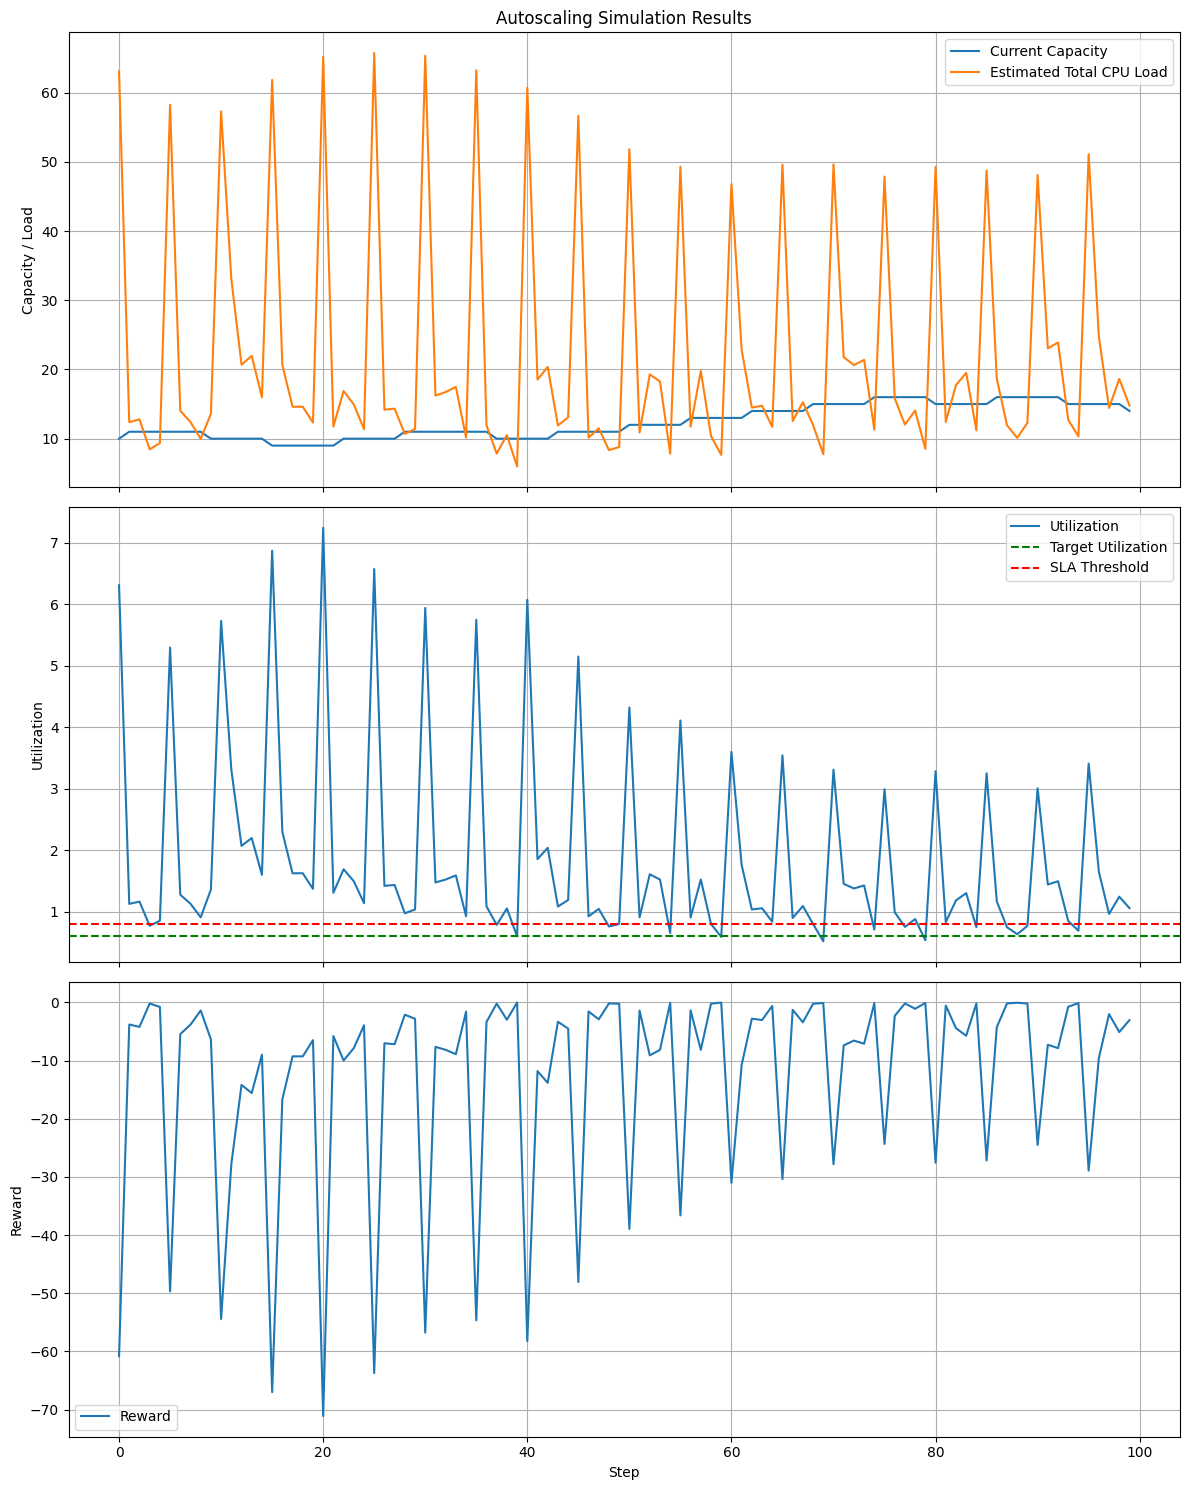

In [15]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

# Plot Current Capacity and Estimated Total CPU Load
axes[0].plot(simulation_results_df.index, simulation_results_df['current_capacity'], label='Current Capacity')
axes[0].plot(simulation_results_df.index, simulation_results_df['estimated_total_cpu_load'], label='Estimated Total CPU Load')
axes[0].set_ylabel('Capacity / Load')
axes[0].set_title('Autoscaling Simulation Results')
axes[0].legend()
axes[0].grid(True)

# Plot Utilization and Target Utilization
axes[1].plot(simulation_results_df.index, simulation_results_df['utilization'], label='Utilization')
axes[1].axhline(y=env.target_utilization, color='g', linestyle='--', label='Target Utilization')
axes[1].axhline(y=env.sla_threshold, color='r', linestyle='--', label='SLA Threshold')
axes[1].set_ylabel('Utilization')
axes[1].legend()
axes[1].grid(True)

# Plot Reward
axes[2].plot(simulation_results_df.index, simulation_results_df['reward'], label='Reward')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Reward')
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

## Collect simulation data

### Subtask:
Store the relevant data from each step of the simulation (e.g., current capacity, utilization, reward) in a list or DataFrame.

**Reasoning**:
Create a Pandas DataFrame from the collected simulation data, extract relevant information from the infos list, add it to the DataFrame, and include step number, action, and reward. Finally, display the head of the DataFrame.

In [16]:
# Create a DataFrame from the collected data
simulation_results_df = pd.DataFrame({
    'step': range(num_simulation_steps),
    'action': actions,
    'reward': rewards
})

# Extract information from the 'infos' list and add as columns
simulation_results_df['current_capacity'] = [info['current_capacity'] for info in infos]
simulation_results_df['utilization'] = [info['utilization'] for info in infos]
simulation_results_df['estimated_total_cpu_load'] = [info['estimated_total_cpu_load'] for info in infos]
# Extract reward components if available, handling potential missing keys
simulation_results_df['cost_penalty'] = [info['reward_components'].get('cost_penalty', np.nan) for info in infos]
simulation_results_df['sla_penalty'] = [info['reward_components'].get('sla_penalty', np.nan) for info in infos]
simulation_results_df['util_deviation_penalty'] = [info['reward_components'].get('util_deviation_penalty', np.nan) for info in infos]


# Set the step number as the index
simulation_results_df.set_index('step', inplace=True)

# Display the first few rows of the DataFrame
display(simulation_results_df.head())

,action,reward,current_capacity,utilization,estimated_total_cpu_load,cost_penalty,sla_penalty,util_deviation_penalty
step,,,,,,,,
0,1,-60.808118,10,6.308011,63.080107,-0.020,-55.080107,-5.708011
1,2,-3.804582,11,1.125689,12.382582,-0.022,-3.256893,-0.525689
2,0,-4.215928,11,1.163084,12.793928,-0.022,-3.630843,-0.563084
3,1,-0.191134,11,0.769134,8.460470,-0.022,-0.000000,-0.169134
4,0,-0.785361,11,0.851215,9.363361,-0.022,-0.512147,-0.251215


## Experiment 1 - DQN

###Create the Agent

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque


# Define the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNAgent:
    """Interacts with and learns from the environment."""

    def __init__(self, observation_space_shape, action_space_size, seed, buffer_size=int(1e5), batch_size=64, gamma=0.99, lr=5e-4, tau=1e-3, update_every=4):
        """Initialize a DQNAgent object.

        Args:
            observation_space_shape (tuple): The shape of the observation space.
            action_space_size (int): The number of possible actions.
            seed (int): Random seed.
            buffer_size (int): Maximum size of replay buffer.
            batch_size (int): Size of training batch.
            gamma (float): Discount factor.
            lr (float): Learning rate.
            tau (float): For soft update of target parameters.
            update_every (int): How often to update the network.
        """
        self.observation_space_shape = observation_space_shape
        self.action_space_size = action_space_size
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every

        # Q-Network
        self.qnetwork_local = QNetwork(observation_space_shape, action_space_size).to(device)
        self.qnetwork_target = QNetwork(observation_space_shape, action_space_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Initialize time step (for updating every `update_every` steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience
        self.memory.add(state, action, reward, next_state, done)

        # Learn every `update_every` time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def select_action(self, state, eps=0.):
        """Returns actions for given state as per epsilon-greedy policy.

        Args:
            state (np.ndarray): Current state.
            eps (float): Epsilon for epsilon-greedy action selection.

        Returns:
            int: Action to take.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() # Set the network to evaluation mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train() # Set the network back to training mode

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_space_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Args:
            experiences (tuple): Tuple of (states, actions, rewards, next_states, dones).
            gamma (float): Discount factor.
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expecteds = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = nn.MSELoss()(Q_expecteds, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network parameters
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Args:
            local_model (torch.nn.Module): PyTorch model (weights will be copied from).
            target_model (torch.nn.Module): PyTorch model (weights will be copied to).
            tau (float): Interpolation parameter.
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

###Create the QNetwork

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the Q-Network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, observation_space_shape, action_space_size, hidden_size=64):
        """
        Initializes the Q-Network.

        Args:
            observation_space_shape (tuple): The shape of the observation space.
            action_space_size (int): The number of possible actions.
            hidden_size (int): The number of neurons in the hidden layers.
        """
        super(QNetwork, self).__init__()

        # Get the number of features from the observation space shape
        input_features = observation_space_shape[0]

        self.fc1 = nn.Linear(input_features, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_space_size)

    def forward(self, state):
        """
        Performs a forward pass through the network.

        Args:
            state (torch.Tensor): The input state.

        Returns:
            torch.Tensor: The output Q-values for each action.
        """
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

###Create the Replay Buffer

In [22]:
import random
from collections import deque
import numpy as np

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Args:
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = (None, None, None, None, None) # State, Action, Reward, Next State, Done
        self.seed = random.seed(0)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = (state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(device)


        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

###Create the Training Loop

In [23]:
# Set up hyperparameters for training
num_episodes = 500  # Number of training episodes
max_steps_per_episode = 1000  # Maximum steps per episode

# Epsilon-greedy exploration schedule
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

# Initialize the environment and agent
env = AutoScalingEnv(df_usage)  # Use the environment created earlier
agent = DQNAgent(
    observation_space_shape=env.observation_space.shape,
    action_space_size=env.action_space.n,
    seed=0
)

# List to store rewards per episode
scores = []

# Training loop
epsilon = epsilon_start
for i_episode in range(1, num_episodes + 1):
    # Reset the environment at the beginning of each episode
    state, info = env.reset()
    score = 0
    done = False
    truncated = False

    # Run the episode
    for t in range(max_steps_per_episode):
        # Select an action using the agent's policy (epsilon-greedy)
        action = agent.select_action(state, epsilon)

        # Take the selected action in the environment
        next_state, reward, terminated, truncated, info = env.step(action)

        # Agent takes a step in its learning process
        agent.step(state, action, reward, next_state, terminated or truncated)

        # Update the current state and score
        state = next_state
        score += reward

        # Check if the episode is finished
        if terminated or truncated:
            break

    # Append the total score for the episode
    scores.append(score)

    # Decay epsilon
    epsilon = max(epsilon_end, epsilon_decay * epsilon)

    # Print training progress
    if i_episode % 10 == 0:
        print(f'Episode {i_episode}\tAverage Score: {np.mean(scores[-10:]):.2f}')

print("Training finished.")

Episode 10	Average Score: -40451.25
Episode 20	Average Score: -9784.15
Episode 30	Average Score: -11356.77
Episode 40	Average Score: -6089.86
Episode 50	Average Score: -4736.64
Episode 60	Average Score: -4548.82
Episode 70	Average Score: -3761.30
Episode 80	Average Score: -3339.24
Episode 90	Average Score: -3394.85
Episode 100	Average Score: -2922.56
Episode 110	Average Score: -2852.48
Episode 120	Average Score: -2779.45
Episode 130	Average Score: -2615.66
Episode 140	Average Score: -2713.38
Episode 150	Average Score: -2456.35
Episode 160	Average Score: -2459.11
Episode 170	Average Score: -2346.45
Episode 180	Average Score: -2376.40
Episode 190	Average Score: -2226.79
Episode 200	Average Score: -2334.41
Episode 210	Average Score: -2165.30
Episode 220	Average Score: -2136.95
Episode 230	Average Score: -2146.35
Episode 240	Average Score: -2168.14
Episode 250	Average Score: -2102.47
Episode 260	Average Score: -2109.55
Episode 270	Average Score: -2080.27
Episode 280	Average Score: -2042.70

In [24]:
# Set up hyperparameters for training
num_episodes = 500  # Number of training episodes
max_steps_per_episode = 1000  # Maximum steps per episode

# Epsilon-greedy exploration schedule
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

# Initialize the environment and agent
env = AutoScalingEnv(df_usage)  # Use the environment created earlier
agent = DQNAgent(
    observation_space_shape=env.observation_space.shape,
    action_space_size=env.action_space.n,
    seed=0
)

# List to store rewards per episode
scores = []

# Training loop
epsilon = epsilon_start
for i_episode in range(1, num_episodes + 1):
    # Reset the environment at the beginning of each episode
    state, info = env.reset()
    score = 0
    done = False
    truncated = False

    # Run the episode
    for t in range(max_steps_per_episode):
        # Select an action using the agent's policy (epsilon-greedy)
        action = agent.select_action(state, epsilon)

        # Take the selected action in the environment
        next_state, reward, terminated, truncated, info = env.step(action)

        # Agent takes a step in its learning process
        agent.step(state, action, reward, next_state, terminated or truncated)

        # Update the current state and score
        state = next_state
        score += reward

        # Check if the episode is finished
        if terminated or truncated:
            break

    # Append the total score for the episode
    scores.append(score)

    # Decay epsilon
    epsilon = max(epsilon_end, epsilon_decay * epsilon)

    # Print training progress
    if i_episode % 10 == 0:
        print(f'Episode {i_episode}\tAverage Score: {np.mean(scores[-10:]):.2f}')

print("Training finished.")

Episode 10	Average Score: -40430.52
Episode 20	Average Score: -9488.35
Episode 30	Average Score: -11280.59
Episode 40	Average Score: -6038.84
Episode 50	Average Score: -4837.13
Episode 60	Average Score: -4576.69
Episode 70	Average Score: -3855.47
Episode 80	Average Score: -3275.62
Episode 90	Average Score: -3350.29
Episode 100	Average Score: -2970.18
Episode 110	Average Score: -2742.33
Episode 120	Average Score: -2775.19
Episode 130	Average Score: -2608.64
Episode 140	Average Score: -2713.24
Episode 150	Average Score: -2429.74
Episode 160	Average Score: -2455.33
Episode 170	Average Score: -2344.50
Episode 180	Average Score: -2376.42
Episode 190	Average Score: -2224.44
Episode 200	Average Score: -2328.88
Episode 210	Average Score: -2161.56
Episode 220	Average Score: -2134.12
Episode 230	Average Score: -2146.27
Episode 240	Average Score: -2161.35
Episode 250	Average Score: -2100.34
Episode 260	Average Score: -2111.51
Episode 270	Average Score: -2081.41
Episode 280	Average Score: -2041.79

## Evaluate the Trained Agent

### Subtask:
Evaluate the performance of the trained DQN agent in the `AutoScalingEnv` over a fixed number of episodes or steps.

In [30]:
# Set up evaluation parameters
num_evaluation_episodes = 10  # Number of episodes to run for evaluation
max_steps_per_evaluation_episode = 1000  # Maximum steps per evaluation episode

# Initialize the environment for evaluation (use the same environment)
eval_env = AutoScalingEnv(df_usage)

# List to store evaluation scores
eval_scores = []
evaluation_results = [] # To store detailed results for visualization

# Run evaluation episodes
for i_episode in range(1, num_evaluation_episodes + 1):
    # Reset the environment
    state, info = eval_env.reset()
    score = 0
    done = False
    truncated = False
    episode_results = [] # Store results for this episode

    # Run the episode
    for t in range(max_steps_per_evaluation_episode):
        # Select an action using the trained agent's policy (no exploration, epsilon=0)
        action = agent.select_action(state, eps=0.)

        # Take the selected action in the environment
        next_state, reward, terminated, truncated, info = eval_env.step(action)

        # Store results for this step
        episode_results.append({
            'step': t,
            'action': action,
            'reward': reward,
            'current_capacity': info['current_capacity'],
            'utilization': info['utilization'],
            'estimated_total_cpu_load': info['estimated_total_cpu_load'],
            'cost_penalty': info['reward_components'].get('cost_penalty', np.nan),
            'sla_penalty': info['reward_components'].get('sla_penalty', np.nan),
            'util_deviation_penalty': info['reward_components'].get('util_deviation_penalty', np.nan)
        })

        # Update the current state and score
        state = next_state
        score += reward

        # Check if the episode is finished
        if terminated or truncated:
            break

    # Append the total score for the episode
    eval_scores.append(score)
    evaluation_results.extend(episode_results) # Add episode results to overall list

    print(f'Evaluation Episode {i_episode}\tScore: {score:.2f}')

# Print average evaluation score
print(f'\nAverage Evaluation Score over {num_evaluation_episodes} episodes: {np.mean(eval_scores):.2f}')

# Create a DataFrame from evaluation results for easier analysis and visualization
evaluation_results_df = pd.DataFrame(evaluation_results)
evaluation_results_df.set_index('step', inplace=True)

# Display the first few rows of the evaluation results DataFrame
display(evaluation_results_df.head())

Evaluation Episode 1	Score: -1862.92
Evaluation Episode 2	Score: -1862.92
Evaluation Episode 3	Score: -1862.92
Evaluation Episode 4	Score: -1862.92
Evaluation Episode 5	Score: -1862.92
Evaluation Episode 6	Score: -1862.92
Evaluation Episode 7	Score: -1862.92
Evaluation Episode 8	Score: -1862.92
Evaluation Episode 9	Score: -1862.92
Evaluation Episode 10	Score: -1862.92

Average Evaluation Score over 10 episodes: -1862.92


,action,reward,current_capacity,utilization,estimated_total_cpu_load,cost_penalty,sla_penalty,util_deviation_penalty
step,,,,,,,,
0,2,-54.502107,11,5.734555,63.080107,-0.022,-49.345552,-5.134555
1,2,-3.804582,11,1.125689,12.382582,-0.022,-3.256893,-0.525689
2,2,-4.215928,11,1.163084,12.793928,-0.022,-3.630843,-0.563084
3,2,-0.191134,11,0.769134,8.460470,-0.022,-0.000000,-0.169134
4,2,-0.785361,11,0.851215,9.363361,-0.022,-0.512147,-0.251215


### Visualize Evaluation Results

Plot the collected evaluation data to visualize the agent's performance and the environment's state over time.

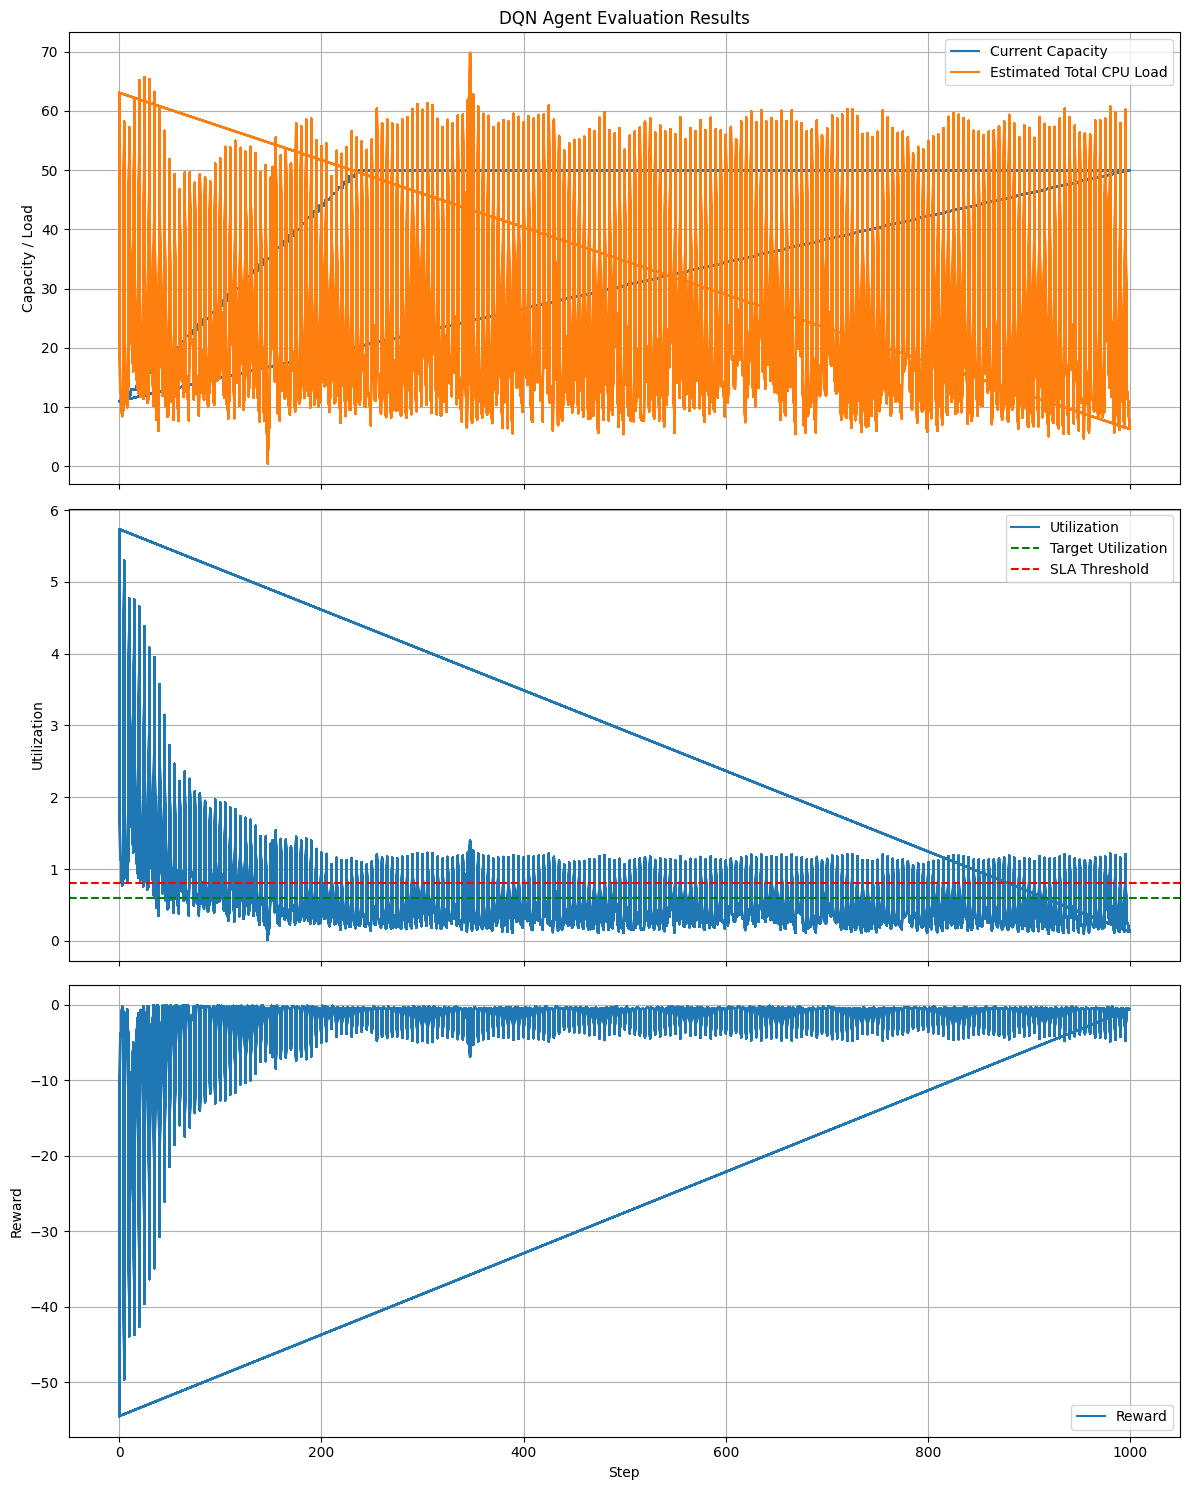

In [31]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

# Plot Current Capacity and Estimated Total CPU Load during evaluation
axes[0].plot(evaluation_results_df.index, evaluation_results_df['current_capacity'], label='Current Capacity')
axes[0].plot(evaluation_results_df.index, evaluation_results_df['estimated_total_cpu_load'], label='Estimated Total CPU Load')
axes[0].set_ylabel('Capacity / Load')
axes[0].set_title('DQN Agent Evaluation Results')
axes[0].legend()
axes[0].grid(True)

# Plot Utilization and Target Utilization during evaluation
axes[1].plot(evaluation_results_df.index, evaluation_results_df['utilization'], label='Utilization')
axes[1].axhline(y=env.target_utilization, color='g', linestyle='--', label='Target Utilization')
axes[1].axhline(y=env.sla_threshold, color='r', linestyle='--', label='SLA Threshold')
axes[1].set_ylabel('Utilization')
axes[1].legend()
axes[1].grid(True)

# Plot Reward during evaluation (already plotted but including for completeness in a single figure)
axes[2].plot(evaluation_results_df.index, evaluation_results_df['reward'], label='Reward')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Reward')
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()